<a href="https://colab.research.google.com/github/Guilherm0/Recommendation-System/blob/main/RecomendacaoJogos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sistemas de Recomendação** - **Prática**

# Import libraries and datasets

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

**Upload file steam-200k.csv**

Schema:

| Column    | Type   | Description 
|-----------|--------|-------------
| user_id   | int    | User identifier 
| item_id   | string | Name of the steam game
| behaviour | string | Behavior name (purchase/play)
| hours     | float  | Hours if behavior is play, 1.0 if behavior is purchase
| blank     | int    | Column to ignore

Source: [Steam Video Games (Kaggle)](https://www.kaggle.com/datasets/tamber/steam-video-games?resource=download)

In [ ]:
%%time
_ = files.upload()

Saving steam-200k.csv to steam-200k.csv
CPU times: user 1.72 s, sys: 226 ms, total: 1.94 s
Wall time: 2min 12s


In [ ]:
df = pd.read_csv('steam-200k.csv', header=None, names=['user_id', 'item_id', 'behaviour', 'hours', 'blank'])
df.drop(columns=['blank'], inplace=True)
df.tail()

,user_id,item_id,behaviour,hours
199995,128470551,Titan Souls,play,1.5
199996,128470551,Grand Theft Auto Vice City,purchase,1.0
199997,128470551,Grand Theft Auto Vice City,play,1.5
199998,128470551,RUSH,purchase,1.0
199999,128470551,RUSH,play,1.4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    200000 non-null  int64  
 1   item_id    200000 non-null  object 
 2   behaviour  200000 non-null  object 
 3   hours      200000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.1+ MB


# Recomendação Não-Personalizada

## Top N jogos mais comprados

Recomende os Top N jogos mais comprados para todos os usuários

In [ ]:
df.head()

,user_id,item_id,behaviour,hours
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [ ]:
def recommend_top_n_purchased_games(df:pd.DataFrame, n:int) -> pd.DataFrame:
  """Recommends the N most purchased games from Steam"""
  df_top_purchase = (
    df
    .query('behaviour == "purchase"')
    .groupby('item_id')
    .agg({'user_id': 'count'})
    .reset_index()
    .rename({'user_id': 'score'}, axis=1)
    .sort_values(by='score', ascending=False)
    .head(n)
  )
  return df_top_purchase

df_top_purchase = recommend_top_n_purchased_games(df, n=10)
df_top_purchase

,item_id,score
1336,Dota 2,4841
4257,Team Fortress 2,2323
4788,Unturned,1563
981,Counter-Strike Global Offensive,1412
2074,Half-Life 2 Lost Coast,981
984,Counter-Strike Source,978
2475,Left 4 Dead 2,951
978,Counter-Strike,856
4899,Warframe,847
2071,Half-Life 2 Deathmatch,823


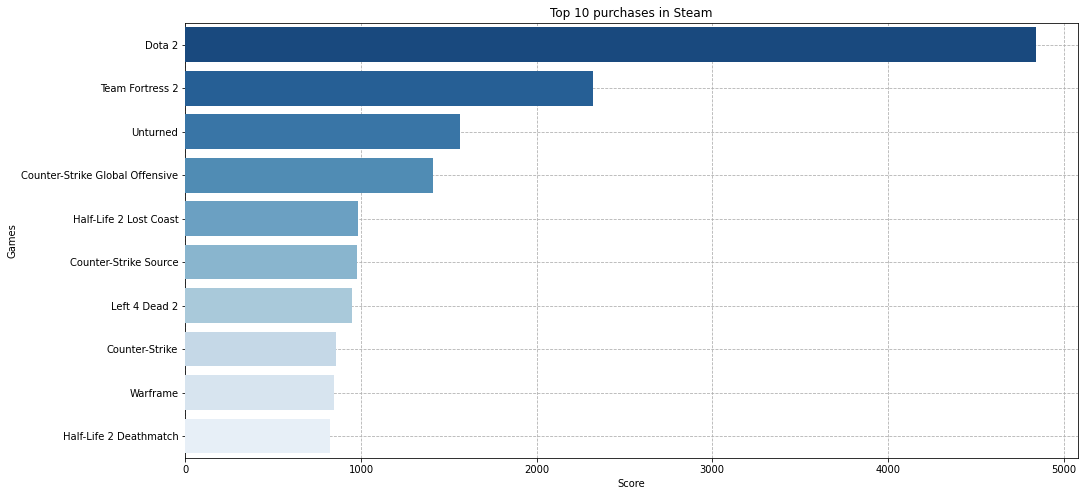

In [ ]:
def plot_non_personalized_recommendations(df:pd.DataFrame, title:str, figsize=(16, 8)) -> None:
  """Plots top n games in Steam"""
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
  sns.barplot(data=df, x='score', y='item_id', ax=ax, palette='Blues_r', zorder=3)
  ax.set_xlabel('Score')
  ax.set_ylabel('Games')
  ax.set_title(f'Top {df.shape[0]} purchases in Steam')
  ax.grid(True, linestyle='--', zorder=0)

plot_non_personalized_recommendations(df_top_purchase, title=f'Top {df_top_purchase.shape[0]} purchases in Steam')

## Top N mais jogados

Recomende os N jogos mais jogados em horas.

Variações:

- Total de horas do usuário
- Média de horas do usuário

In [ ]:
df.head()

,user_id,item_id,behaviour,hours
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [ ]:
def recommend_top_n_played_games(df:pd.DataFrame, n:int, aggregation_fn='sum') -> pd.DataFrame:
  df_top_played = (
      df
      .query('behaviour == "play"')
      .groupby('item_id')
      .agg({'hours': aggregation_fn})
      .reset_index()
      .rename({'hours': 'score'}, axis=1)
      .sort_values(by='score', ascending=False)
      .head(n)
  )

  return df_top_played

df_top_played = recommend_top_n_played_games(df, n=10, aggregation_fn='sum')
df_top_played

,item_id,score
922,Dota 2,981684.6
673,Counter-Strike Global Offensive,322771.6
2994,Team Fortress 2,173673.3
670,Counter-Strike,134261.1
2691,Sid Meier's Civilization V,99821.3
675,Counter-Strike Source,96075.5
3067,The Elder Scrolls V Skyrim,70889.3
1313,Garry's Mod,49725.3
490,Call of Duty Modern Warfare 2 - Multiplayer,42009.9
1733,Left 4 Dead 2,33596.7


# Recomendação Personalizada

## Preference Score

Pontuação de preferência (_rating_) do usuário $u$ para o item $i$: 

$$r_{\mathbf{ui}} = \frac{horas\ que\ \mathbf{u}\ jogou\ o\ jogo\ \mathbf{i}}{horas\ totais\ que\ \mathbf{u}\ jogou}$$

Matriz de Preferências:

$$
\mathbf{R} = \begin{equation}
\begin{pmatrix}
  r_{11}       & r_{21}   & \cdots  & r_{1i} \\
  r_{21}       & r_{22}   & \cdots  & r_{2i} \\
  \vdots       & \vdots   & \ddots  & \vdots \\
  r_{u1}       & r_{u2}   & \cdots  & r_{ui} \\
\end{pmatrix}
\end{equation}
$$

In [ ]:
df.head()

,user_id,item_id,behaviour,hours
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [ ]:
df_user_consumption = (
    df
    .query('behaviour == "play"')[['user_id', 'item_id', 'hours']]
    .groupby('user_id')['hours']
    .sum()
    .reset_index()
    .rename({'hours': 'total_user_hours'}, axis=1)
)

df_user_consumption

,user_id,total_user_hours
0,5250,225.5
1,76767,1227.0
2,86540,255.0
3,144736,0.1
4,181212,2.2
...,...,...
11345,309434439,0.8
11346,309554670,5.9
11347,309626088,6.7
11348,309824202,0.7


In [ ]:
df_ratings = (
  df
  .query('behaviour == "play"')
  .groupby(['user_id', 'item_id'])['hours']
  .sum()
  .reset_index()
  .merge(df_user_consumption, on='user_id')
)

df_ratings['rating'] = df_ratings['hours']/df_ratings['total_user_hours']
df_ratings.drop(columns=['hours', 'total_user_hours'], inplace=True)
df_ratings

,user_id,item_id,rating
0,5250,Alien Swarm,0.021729
1,5250,Cities Skylines,0.638581
2,5250,Deus Ex Human Revolution,0.274945
3,5250,Dota 2,0.000887
4,5250,Portal 2,0.060310
...,...,...,...
70472,309434439,Dota 2,1.000000
70473,309554670,Mitos.is The Game,1.000000
70474,309626088,Age of Empires II HD Edition,1.000000
70475,309824202,Dota 2,1.000000


## Preference Matrix

In [ ]:
df_preference_matrix = (
  df_ratings
  .pivot(index='user_id', columns='item_id', values='rating')
  .fillna(0)
)

df_preference_matrix

item_id,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
user_id,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309434439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
309554670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
309626088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


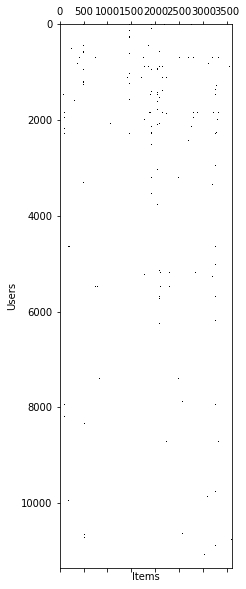

In [ ]:
def plot_matrix_sparsity(df_matrix:pd.DataFrame, figsize=(10, 10)):
  """Plots each filled value of the matrix as a dot"""
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
  ax.spy(df_matrix)
  ax.set_ylabel('Users')
  ax.set_xlabel('Items')

plot_matrix_sparsity(df_preference_matrix)

## Item-based Collaborative Filtering

Dado um _seed_, recomende itens semelhantes.

Estratégia de similaridade: itens com consumos comuns dos usuários

**Observação**: isso pode ser feito com a matriz de similaridade baseada em conteúdo

In [ ]:
df_preference_matrix.T

user_id,5250,76767,86540,144736,181212,229911,298950,381543,547685,554278,...,309228590,309255941,309262440,309265377,309404240,309434439,309554670,309626088,309824202,309903146
item_id,,,,,,,,,,,,,,,,,,,,,
007 Legends,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0RBITALIS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Second Ninja,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"10,000,000",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rymdkapsel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sZone-Online,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the static speaks my name,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def get_similarity_matrix(df_preference_matrix:pd.DataFrame, users:np.array=None) -> pd.DataFrame:
  """ Generates item similarity matrix from preference matrix for all or selected users """
  item_ids = df_preference_matrix.columns

  if users is None:
    users = df_preference_matrix.index

  # complete
  similarity_matrix = cosine_similarity(df_preference_matrix.loc[users].T)
  similarity_matrix = pd.DataFrame(
      similarity_matrix,
      index=item_ids,
      columns=item_ids
  )

  return similarity_matrix

similarity_matrix = get_similarity_matrix(df_preference_matrix, users=None)
similarity_matrix

item_id,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
item_id,,,,,,,,,,,,,,,,,,,,,
007 Legends,1.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
0RBITALIS,0.0,1.000000,0.000000e+00,0.077751,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.000000e+00,2.367356e-05,0.000000
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),0.0,0.000000,1.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,2.948747e-07,0.000000e+00,0.000000e+00,0.000000
10 Second Ninja,0.0,0.077751,0.000000e+00,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
"10,000,000",0.0,0.000000,0.000000e+00,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rymdkapsel,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
sZone-Online,0.0,0.000000,2.948747e-07,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000e+00,9.935406e-06,4.747041e-05,0.000000
the static speaks my name,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,9.935406e-06,1.000000e+00,6.734307e-07,0.000000


In [ ]:
def recommend_n_most_similars(item_id:int, similarity_matrix:pd.DataFrame, n:int):
  assert item_id in similarity_matrix.index
  item_similarities = similarity_matrix.loc[item_id]
  # complete
  top_n_similars = (
      item_similarities
      .sort_values(ascending=False)
      .head(n+1)
      .reset_index()
      .rename({item_id: 'score'}, axis=1)
      .query('item_id != @item_id')
  )
  return top_n_similars

recommendations = recommend_n_most_similars(item_id='Fallout 4', similarity_matrix=similarity_matrix, n=10)
recommendations

,item_id,score
1,Doctor Who The Eternity Clock,0.415898
2,Darkest Dungeon,0.402976
3,Batman Arkham City,0.192517
4,Hatred,0.188185
5,Metro 2033,0.169520
6,Aveyond 3-1 Lord of Twilight,0.167022
7,SanctuaryRPG Black Edition,0.167022
8,Forsaken World,0.167018
9,The Cat and the Coup,0.166829
10,Penny Arcade's On the Rain-Slick Precipice of ...,0.165131


In [ ]:
similarity_matrix = get_similarity_matrix(df_preference_matrix, users=None)
recommendations = recommend_n_most_similars(item_id='Counter-Strike Global Offensive', similarity_matrix=similarity_matrix, n=10)
recommendations

,item_id,score
0,Counter-Strike Global Offensive,1.000000
1,Call of Duty Black Ops - Multiplayer OSX,0.061902
2,Sine Mora,0.048367
3,hocus,0.046942
4,Rivals of Aether,0.046624
5,Bob Was Hungry,0.045764
6,aerofly RC 7,0.045191
7,BEEP,0.044886
8,Jet Gunner,0.044251
9,Cabela's Dangerous Hunts 2013,0.044073


In [ ]:
df_ratings

,user_id,item_id,rating
0,5250,Alien Swarm,0.021729
1,5250,Cities Skylines,0.638581
2,5250,Deus Ex Human Revolution,0.274945
3,5250,Dota 2,0.000887
4,5250,Portal 2,0.060310
...,...,...,...
70472,309434439,Dota 2,1.000000
70473,309554670,Mitos.is The Game,1.000000
70474,309626088,Age of Empires II HD Edition,1.000000
70475,309824202,Dota 2,1.000000


In [ ]:
n_users = 2000
most_active_users = (
    df_ratings
    .groupby('user_id')['item_id']
    .count()
    .sort_values(ascending=False)
    .head(n_users)
)

most_active_users

user_id
62990992     498
11403772     314
138941587    299
47457723     298
49893565     297
            ... 
231060378      6
7249363        6
162068651      6
155963474      6
216688763      6
Name: item_id, Length: 2000, dtype: int64

In [ ]:
similarity_matrix = get_similarity_matrix(df_preference_matrix, users=most_active_users.index)

In [ ]:
recommendations = recommend_n_most_similars(item_id='Counter-Strike Global Offensive', similarity_matrix=similarity_matrix, n=10)
recommendations

,item_id,score
0,Counter-Strike Global Offensive,1.000000
1,Defy Gravity,0.119886
2,Dota 2,0.114863
3,Counter-Strike Source,0.114790
4,Caster,0.097510
5,Garry's Mod,0.097373
6,Hurtworld,0.095392
7,hocus,0.094318
8,aerofly RC 7,0.090799
9,PAYDAY 2,0.089596


## Playground

In [ ]:
df_top_purchase

,item_id,score
1336,Dota 2,4841
4257,Team Fortress 2,2323
4788,Unturned,1563
981,Counter-Strike Global Offensive,1412
2074,Half-Life 2 Lost Coast,981
984,Counter-Strike Source,978
2475,Left 4 Dead 2,951
978,Counter-Strike,856
4899,Warframe,847
2071,Half-Life 2 Deathmatch,823


In [ ]:
# item_id = 'Half-Life 2 Lost Coast'
item_id = 'Left 4 Dead 2'

recommendations = recommend_n_most_similars(item_id=item_id, similarity_matrix=similarity_matrix, n=10)
recommendations

,item_id,score
0,Left 4 Dead 2,1.000000
1,Romance of the Three Kingdoms Maker,0.240329
2,Left 4 Dead,0.210711
3,Borderlands 2 RU,0.187502
4,Street Fighter IV,0.152452
5,Cosmophony,0.150114
6,Half-Life Source,0.131123
7,Blur,0.123117
8,Spelunky,0.122406
9,Insurgency,0.118297
